### Algorithms tested

- LinearRegression
- DecisionTreeRegressor
- RandomForrestRegressor
- Ridge
- Lasso
- SVR
- MLPRegressor
- KNeighborsRegressor

Longer list at https://towardsdatascience.com/choosing-a-scikit-learn-linear-regression-algorithm-dd96b48105f5

### Techniques tried

- (All except highly-cardinal done) Encoding remaining categorical data
- Binning some features (minimal effect)
- Converting to a categorical target  (minimal effect)
- See if different time periods are same set of experiments (they were)
- Mean encoding

### Things left to work on

- Understand each model type
- Ensemble methods
- Feature selection / importance
- Reverse engineer price model



In [13]:
#Speed Up autocomplete
%config Completer.use_jedi = False
#can use ipython locate profile to find your current profile directory, and edit the ipython_config.py to add c.IPCompleter.use_jedi = False

# 1. Import Models & Poltting Library

In [14]:
import numpy as np
import pandas as pd

#Data Processing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.preprocessing import MinMaxScaler

#models
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures

#Metrics
from sklearn.metrics import r2_score
import sklearn.metrics as metrics
from sklearn.model_selection import cross_val_score
import statsmodels.api as sm

#Plotting - Matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
%matplotlib inline

#Plotting - YellowBrick
from yellowbrick.datasets import load_concrete
from yellowbrick.regressor import ResidualsPlot

# 2. Data Loaders

In [18]:
#Data Dictionary 
ddict = pd.read_csv('data-dictionary.csv')
#ddict

In [19]:
def bin_column(col, bin_size):
    
    mini = 15 #col.min()
    maxi = int(col.max())

    bins = list(range(mini, maxi, bin_size))

    return list(pd.cut(col, len(bins), labels=bins ))

In [20]:
def target_cols_at_end(cols, targets):

    for t in targets:
        if t in cols:
            cols.remove(t)

        cols.append(t)

    return cols

#target_cols_at_end(list(df.columns), insurers)

#### This section pre-processes the data. Items can be commented in or out to change the pore-processing used

In [21]:
#Load the whole dataset to memory
df = pd.read_csv('data.csv')
df.columns

Index(['YEARLYKM', 'LICCANCNT', 'OWNERAGE', 'MVINSURER', 'REGUSE', 'MAKE',
       'MVINSYEARS', 'MANUFYEAR', 'YDAGE', 'MODEL', 'ATFAULTACCDS', 'NRMAASST',
       'NOYRLICOBT', 'MVINSTYPE', 'DEMERITPTS', 'NCBPCT', 'COMREGVEH',
       'YDGENDER', 'ATFAULT5YRS', 'SHAPE', 'VEHAGE', 'INSURER1_PREMIUM',
       'INSURER2_PREMIUM', 'INSURER3_PREMIUM', 'INSURER4_PREMIUM',
       'COMMENCEDATE'],
      dtype='object')

In [22]:
#Load the whole dataset to memory
df = pd.read_csv('data.csv')

#This dataset has 4 target columns. 1 for each of 4 insurers
target_columns = ['INSURER1_PREMIUM', 'INSURER2_PREMIUM', 'INSURER3_PREMIUM', 'INSURER4_PREMIUM']

#Pick 1 of the insurers as the target for this experiment
target_insurer = target_columns[2]


# Select only numeric columns only
#df = df[df.describe().columns]

#remove rows that are skewing the results
#df = df[df['INSURER3_PREMIUM'] < 388]

#Remove highly co-linear features (MANUFYEAR & VEHAGE are effectively the same thing)
df = df.drop('MANUFYEAR', axis=1)

#period 1 only
#df = df[df.COMMENCEDATE == '2019-07-01'].drop(['COMMENCEDATE'], axis=1)

#period 2 only
#df = df[df.COMMENCEDATE == '2019-09-01'].drop(['COMMENCEDATE'], axis=1)



### CATEGORIC TO NUMERIC CONVERTER ###

#Show the set of non-numeric columns
print(list(set(df.columns) - set(df.describe().columns)))

# #Convert STR to INT
df['REGUSE'].replace(['PRIV', 'BUSG'], [0,1], inplace=True)
df['ATFAULT5YRS'].replace(['N', 'Y'], [0,1], inplace=True)
df['COMREGVEH'].replace(['N', 'Y'], [0,1], inplace=True)

#Show the remaning set of non-numeric columns
print(list(set(df.columns) - set(df.describe().columns)))

# #One Hot Encode columns with <10 unique()
for i in list(set(df.columns) - set(df.describe().columns)):
    if len(df[i].unique()) < 10:
        df = pd.concat([df, pd.get_dummies(df[i], prefix=i, drop_first=True)], axis=1).drop([i] ,axis=1)

#Show the remaning set of non-numeric columns
print(list(set(df.columns) - set(df.describe().columns)))

# #Drop remaining columns with >10 unique()  
# df = df.drop(list(set(df.columns) - set(df.describe().columns)), axis=1)

# Mean Encode the high-cardinality categorical columns
cols = list(set(df.columns) - set(df.describe().columns))  #['MAKE', 'MODEL']

for col in cols:
    means = df.groupby(col)[target_insurer].mean()
    df[col] = df[col].map(means)

#reorder the columns with target variables at end (for X, y split)
df = df[target_cols_at_end(list(df.columns), target_columns)]

### NORMALISE FEATURE COLS ###
# #take out target cols (not normalising them)
# y = df[df.columns[-4:]]

# #Normalise The Feature columns
# scaler = MinMaxScaler()
# X = pd.DataFrame(scaler.fit_transform(df[df.columns[:-4]]), columns=df.columns[:-4])

# #Re-attach the Target columns
# df = pd.concat([X, y], axis=1)


#BINNING (Makes the model less predictive)
# df.OWNERAGE = bin_column(df.OWNERAGE, 5)
# df.YDAGE = bin_column(df.YDAGE, 5)
# df[target_insurer] = bin_column(df[target_insurer], 10)

#TRAIN TEST SPLIT
# Features without targets
X = df[df.columns[:-4]]

#Select one of the 4 target columns
y = df[target_insurer]

#train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

['SHAPE', 'YDGENDER', 'COMREGVEH', 'MVINSURER', 'COMMENCEDATE', 'MAKE', 'REGUSE', 'ATFAULT5YRS', 'MODEL', 'MVINSTYPE']
['SHAPE', 'YDGENDER', 'MVINSURER', 'COMMENCEDATE', 'MAKE', 'MODEL', 'MVINSTYPE']
['MODEL', 'MAKE']


In [23]:
X.head(3).T

,0,1,2
YEARLYKM,15.000000,20.00000,5.000000
LICCANCNT,0.000000,0.00000,0.000000
OWNERAGE,68.000000,31.00000,59.000000
REGUSE,0.000000,0.00000,0.000000
MAKE,307.830222,308.01974,282.751337
MVINSYEARS,4.000000,0.00000,1.000000
YDAGE,68.000000,31.00000,59.000000
MODEL,299.976170,305.11260,284.611248
ATFAULTACCDS,0.000000,0.00000,0.000000
NRMAASST,5.000000,-1.00000,1.000000


# 3. Run Algorithms
## Linear regression

In [24]:
# statsmodel intro video https://youtu.be/V86gTgL1FRw

import statsmodels.api as sm

#Using Stats model

X2 = sm.add_constant(X_train.values)
est = sm.OLS(y_train, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:       INSURER3_PREMIUM   R-squared:                       0.735
Model:                            OLS   Adj. R-squared:                  0.734
Method:                 Least Squares   F-statistic:                     4541.
Date:                Mon, 30 Dec 2019   Prob (F-statistic):               0.00
Time:                        21:19:10   Log-Likelihood:            -2.2440e+05
No. Observations:               47603   AIC:                         4.489e+05
Df Residuals:                   47573   BIC:                         4.491e+05
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         94.4370      2.602     36.297      0.0

In [25]:
#Linear Regression
model = LinearRegression().fit(X_train, y_train)
y_pred = model.predict(X_test)

print('Linear Regression Train: ', model.score(X_train, y_train))

print('\nR2: ', model.score(X_test, y_test))
print('Explained Variance: ', metrics.explained_variance_score(y_test, y_pred))
print('Max Error: ', metrics.max_error(y_test, y_pred))
print('mean_squared_log_error : ', metrics.mean_squared_log_error(y_test, y_pred))

print('\nMAE:', metrics.mean_absolute_error(y_test, y_pred),
      '  MSE:', metrics.mean_squared_error(y_test, y_pred),  
      '  RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Linear Regression Train:  0.7346371289705874

R2:  0.7237843268058267
Explained Variance:  0.7237875050119933
Max Error:  154.14836114894328
mean_squared_log_error :  0.007921254380290586

MAE: 20.743825953699254   MSE: 766.0773813253842   RMSE: 27.67810292135977


#### Quick intuition on how to interpret Linear Model result

The y-intercept is roughly equivalent to the base price in the pricing model

In [26]:
model.intercept_

94.43696865322437

The coefficients for each feature show roughly how much each feature affects price in the pricing model

In [27]:
model.coef_

array([ 4.01116787e-02, -1.69707102e+01,  2.75594624e-01, -8.39861644e+00,
        4.89344803e-01, -8.57459781e+00, -1.41099174e+00,  2.88895109e-01,
        3.02833939e+01, -8.17578376e-01, -1.49971657e+00,  3.02949616e+00,
       -1.24733959e-02, -2.90834253e+00,  3.02833939e+01,  5.01497705e+00,
        7.59396845e+00,  4.22365557e-01,  2.99418517e+00, -1.27856856e+00,
        8.97480339e+00, -2.67569928e-01,  4.82235272e+00, -9.11496756e+01,
       -3.62258990e+01,  7.51159821e-01,  2.16120544e+00,  3.68028760e-02,
        1.23688312e+02,  3.82758562e+01])

To calculate the price for any given example row...

In [28]:
sample_row = df.loc[2][:-4]
sample_row

YEARLYKM                     5.000000
LICCANCNT                    0.000000
OWNERAGE                    59.000000
REGUSE                       0.000000
MAKE                       282.751337
MVINSYEARS                   1.000000
YDAGE                       59.000000
MODEL                      284.611248
ATFAULTACCDS                 0.000000
NRMAASST                     1.000000
NOYRLICOBT                   6.000000
DEMERITPTS                   7.000000
NCBPCT                       0.000000
COMREGVEH                    0.000000
ATFAULT5YRS                  0.000000
VEHAGE                      11.000000
SHAPE_PVF                    0.000000
SHAPE_SED                    1.000000
SHAPE_WAG                    0.000000
YDGENDER_M                   0.000000
YDGENDER_U                   0.000000
MVINSURER_ALLI               0.000000
MVINSURER_GIO                1.000000
MVINSURER_NONE               0.000000
MVINSURER_NRMA               0.000000
MVINSURER_OTH                0.000000
MVINSURER_QB

***

#### The formula y = m(x) + b means "price equals the sample row times the coefficients plus the base price / y-intercept"

In [29]:
price = ((sample_row.values).dot(model.coef_)) + model.intercept_
print("The price to insure this vehicle and driver is $" + str(round(price, 2)))

The price to insure this vehicle and driver is $311.46


#### The Residuals Plot shows the data is distributed reasonably normally

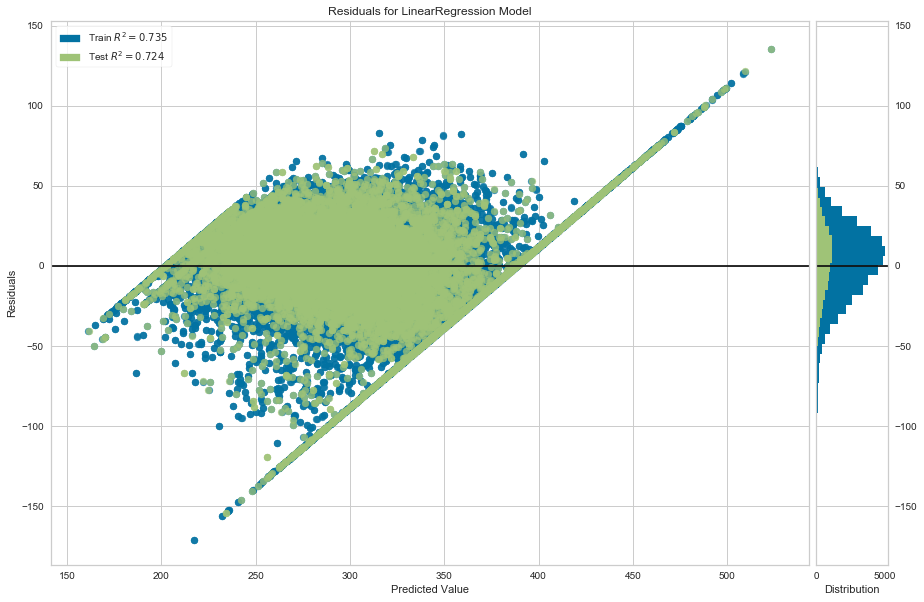

In [30]:
#Residuals Plot

# Instantiate the linear model and visualizer
model = LinearRegression() 
visualizer = ResidualsPlot(model, size=(1080, 720))

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show(figsize=(18, 18)) 

## Ridge Regresson

In [95]:
#RIDGE Regression
model = Ridge(alpha=100).fit(X_train, y_train)
y_pred = model.predict(X_test)

print('Ridge Regression Train: ', model.score(X_train, y_train))

print('\nR2: ', model.score(X_test, y_test))
print('Explained Variance: ', metrics.explained_variance_score(y_test, y_pred))
print('Max Error: ', metrics.max_error(y_test, y_pred))
print('mean_squared_log_error : ', metrics.mean_squared_log_error(y_test, y_pred))

print('\nMAE:', metrics.mean_absolute_error(y_test, y_pred),
      '  MSE:', metrics.mean_squared_error(y_test, y_pred),  
      '  RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Ridge Regression Train:  0.7582380567642414

R2:  0.7579190130201852
Explained Variance:  0.7580291787677712
Max Error:  110.82124777224806
mean_squared_log_error :  0.005300438081456827

MAE: 16.729082056708577   MSE: 445.6007317478146   RMSE: 21.109257015532656


## Lasso Regression

In [96]:
from sklearn import linear_model
model = linear_model.Lasso(alpha=0.1).fit(X_train, y_train)
y_pred = model.predict(X_test)

print('Lasso Regression Train: ', model.score(X_train, y_train))

print('\nR2: ', model.score(X_test, y_test))
print('Explained Variance: ', metrics.explained_variance_score(y_test, y_pred))
print('Max Error: ', metrics.max_error(y_test, y_pred))
print('mean_squared_log_error : ', metrics.mean_squared_log_error(y_test, y_pred))

print('\nMAE:', metrics.mean_absolute_error(y_test, y_pred),
      '  MSE:', metrics.mean_squared_error(y_test, y_pred),  
      '  RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Lasso Regression Train:  0.7570542768322606

R2:  0.7563748363608577
Explained Variance:  0.756491488564414
Max Error:  110.5202316307927
mean_squared_log_error :  0.005329555555730174

MAE: 16.771256817972915   MSE: 448.44311213434855   RMSE: 21.176475441733654


## SVR

In [97]:
# from sklearn.svm import LinearSVR
# model = LinearSVR(random_state=0).fit(X_train, y_train)

# y_pred = model.predict(X_test)

# print('SVR Train: ', model.score(X_train, y_train))

# print('\nR2: ', model.score(X_test, y_test))
# print('Explained Variance: ', metrics.explained_variance_score(y_test, y_pred))
# print('Max Error: ', metrics.max_error(y_test, y_pred))
# print('mean_squared_log_error : ', metrics.mean_squared_log_error(y_test, y_pred))

# print('\nMAE:', metrics.mean_absolute_error(y_test, y_pred),
#       '  MSE:', metrics.mean_squared_error(y_test, y_pred),  
#       '  RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

## Polynomial Regression

In [26]:
# From https://muthu.co/simple-example-of-polynomial-regression-using-python/
# OVER 3rd order sucks   # OVER 6th ORDER WILL MELT CPU
nth_order = 2
model = make_pipeline(PolynomialFeatures(nth_order), LinearRegression())
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print('\nR2: ', model.score(X_test, y_test))
print('Explained Variance: ', metrics.explained_variance_score(y_test, y_pred))
print('Max Error: ', metrics.max_error(y_test, y_pred))
print('mean_squared_log_error : ', metrics.mean_squared_log_error(y_test, y_pred))

print('\nMAE:', metrics.mean_absolute_error(y_test, y_pred),
      '  MSE:', metrics.mean_squared_error(y_test, y_pred),  
      '  RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))


R2:  0.8187327621784412
Explained Variance:  0.818757231169896
Max Error:  132.54615760429272
mean_squared_log_error :  0.0054775693499247045

MAE: 17.140140791361283   MSE: 502.7402292729664   RMSE: 22.42186944197487


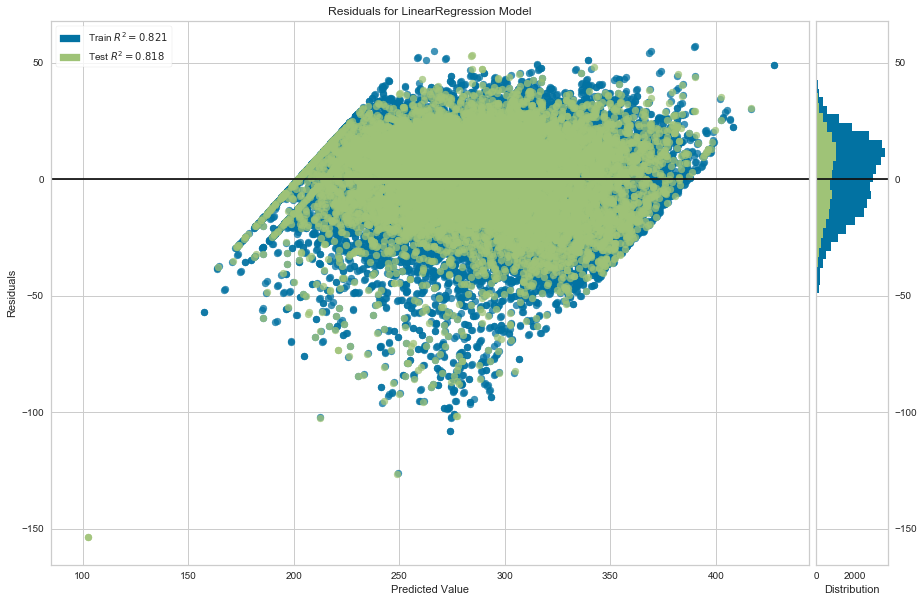

In [99]:
# OVER 3rd order sucks  # OVER 6th ORDER WILL MELT CPU
# Residuals Plot  # Instantiate the model and visualizer
nth_order = 2
model = make_pipeline(PolynomialFeatures(nth_order), LinearRegression())
visualizer = ResidualsPlot(model, size=(1080, 720))

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show(figsize=(18, 18)) 

### Decision Tree Regression

In [94]:
# Decision Tree
model = DecisionTreeRegressor(random_state=0, )
# fit the regressor with X and Y data 
model.fit(X_train, y_train)

y_pred = model.predict(X_test) 

print('R2 Train: ', model.score(X_train, y_train))

print('\nR2 Test: ', model.score(X_test, y_test))
print('Explained Variance: ', metrics.explained_variance_score(y_test, y_pred))
print('Max Error: ', metrics.max_error(y_test, y_pred))
print('mean_squared_log_error : ', metrics.mean_squared_log_error(y_test, y_pred))

print('\nMAE:', metrics.mean_absolute_error(y_test, y_pred),
      '  MSE:', metrics.mean_squared_error(y_test, y_pred),  
      '  RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

R2 Train:  1.0

R2 Test:  0.9879054999681269
Explained Variance:  0.9879088634081727
Max Error:  92.54222464247903
mean_squared_log_error :  0.0003970811634768868

MAE: 1.6159032054145317   MSE: 33.54379860386781   RMSE: 5.791700838602406


In [95]:
model.feature_importances_

array([1.00656605e-03, 3.52212000e-06, 3.98530214e-03, 6.49451995e-04,
       4.39318008e-02, 1.70077179e-01, 2.77249382e-01, 4.21219917e-02,
       1.03816837e-02, 9.62333396e-03, 3.83781916e-04, 1.78208139e-02,
       5.87861833e-04, 2.26956262e-04, 2.45520405e-02, 2.72564000e-01,
       2.17080918e-04, 4.80801339e-04, 1.52150863e-02, 4.94841508e-02,
       6.22978119e-04, 7.49038642e-05, 6.74511875e-04, 4.22843414e-05,
       4.57596391e-04, 1.57013352e-03, 7.48809779e-04, 1.60478872e-02,
       3.91897933e-02, 8.31383161e-06])

### Random Forrest Regression

In [19]:
# Random Forrest
model = RandomForestRegressor(n_estimators=10, min_samples_leaf=3, n_jobs=-1, random_state=0) 
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print('R2 Train: ', model.score(X_train, y_train))

print('\nR2 Test: ', model.score(X_test, y_test))
print('Explained Variance: ', metrics.explained_variance_score(y_test, y_pred))
print('Max Error: ', metrics.max_error(y_test, y_pred))
print('mean_squared_log_error : ', metrics.mean_squared_log_error(y_test, y_pred))

print('\nMAE:', metrics.mean_absolute_error(y_test, y_pred),
      '  MSE:', metrics.mean_squared_error(y_test, y_pred),  
      '  RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

R2 Train:  0.9915757327069146

R2 Test:  0.9776132789610883
Explained Variance:  0.9776138438669997
Max Error:  132.3796452541044
mean_squared_log_error :  0.0006931316604342206

MAE: 4.416146334994533   MSE: 62.08902062518127   RMSE: 7.879658661717604


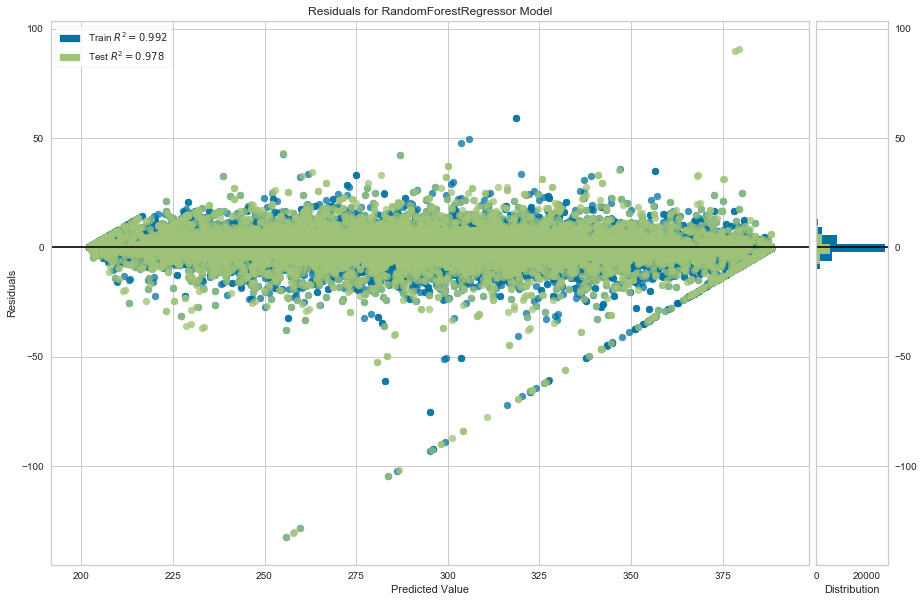

In [20]:
# Residuals Plot   # Instantiate the model and visualizer
model = RandomForestRegressor(n_estimators=10, min_samples_leaf=3, n_jobs=-1, random_state=0) 
visualizer = ResidualsPlot(model, size=(1080, 720))

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show(figsize=(18, 18)) 

## MLP Regressor

In [103]:
# https://www.machinelearningtutorial.net/2017/01/28/python-scikit-simple-function-approximation/
from sklearn.neural_network import MLPRegressor

model = MLPRegressor(alpha=0.01, hidden_layer_sizes = (30,), max_iter = 1000,
                 activation = 'relu', learning_rate = 'adaptive', random_state=0, verbose = 'True')  
model.fit(X_train, y_train)

pred_y = model.predict(X_test)

print('MLP Regression Train: ', model.score(X_train, y_train))

print('\nR2: ', model.score(X_test, y_test))
print('Explained Variance: ', metrics.explained_variance_score(y_test, y_pred))
print('Max Error: ', metrics.max_error(y_test, y_pred))
print('mean_squared_log_error : ', metrics.mean_squared_log_error(y_test, y_pred))

print('\nMAE:', metrics.mean_absolute_error(y_test, y_pred),
      '  MSE:', metrics.mean_squared_error(y_test, y_pred),  
      '  RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Iteration 1, loss = 4291.29313519
Iteration 2, loss = 688.74344589
Iteration 3, loss = 496.60137682
Iteration 4, loss = 402.20038475
Iteration 5, loss = 343.80235905
Iteration 6, loss = 304.62665356
Iteration 7, loss = 283.28341784
Iteration 8, loss = 273.16901730
Iteration 9, loss = 266.09819105
Iteration 10, loss = 260.80824209
Iteration 11, loss = 257.07600052
Iteration 12, loss = 251.57042351
Iteration 13, loss = 248.76225786
Iteration 14, loss = 245.80993178
Iteration 15, loss = 242.59501405
Iteration 16, loss = 240.92011789
Iteration 17, loss = 238.34649797
Iteration 18, loss = 237.16313025
Iteration 19, loss = 235.31290468
Iteration 20, loss = 232.70011779
Iteration 21, loss = 232.48665128
Iteration 22, loss = 229.61024541
Iteration 23, loss = 227.84171506
Iteration 24, loss = 226.19895876
Iteration 25, loss = 223.85466131
Iteration 26, loss = 222.79726507
Iteration 27, loss = 218.51354008
Iteration 28, loss = 216.15036837
Iteration 29, loss = 211.79389586
Iteration 30, loss = 2

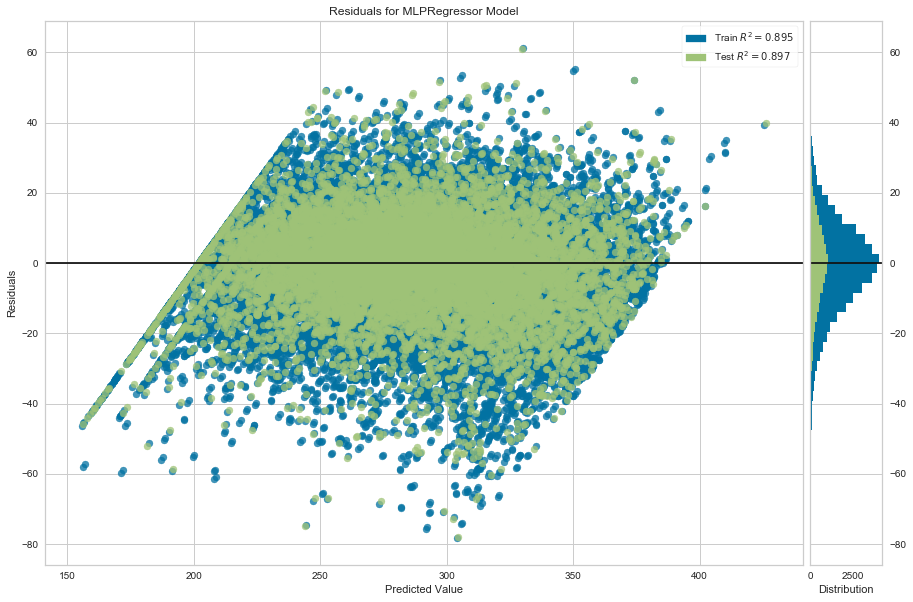

In [104]:
visualizer = ResidualsPlot(model, size=(1080, 720))

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show(figsize=(18, 18)) 

## KNNRegressor

In [105]:
from sklearn import neighbors
model = neighbors.KNeighborsRegressor(n_neighbors = 5)
model.fit(X_train, y_train)  #fit the model
y_pred=model.predict(X_test)

print('R2 Train: ', model.score(X_train, y_train))

print('\nR2 Test: ', model.score(X_test, y_test))
print('Explained Variance: ', metrics.explained_variance_score(y_test, y_pred))
print('Max Error: ', metrics.max_error(y_test, y_pred))
print('mean_squared_log_error : ', metrics.mean_squared_log_error(y_test, y_pred))

print('\nMAE:', metrics.mean_absolute_error(y_test, y_pred),
      '  MSE:', metrics.mean_squared_error(y_test, y_pred),  
      '  RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

R2 Train:  0.8783273274323582

R2 Test:  0.8006676107793904
Explained Variance:  0.8008590537949805
Max Error:  124.04673399738601
mean_squared_log_error :  0.004478254549663753

MAE: 13.725435870345501   MSE: 366.9129889376649   RMSE: 19.154972955806148


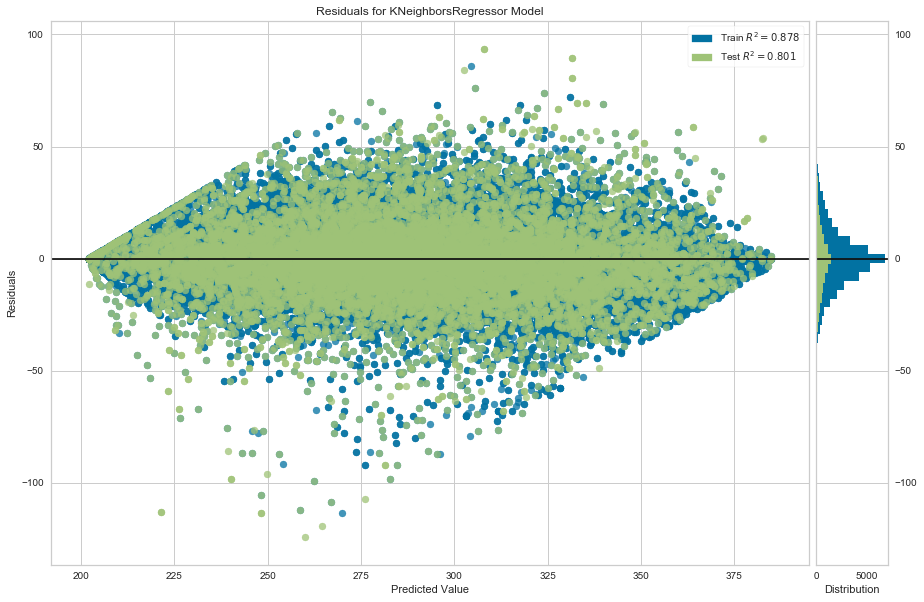

In [106]:
visualizer = ResidualsPlot(model, size=(1080, 720))

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show(figsize=(18, 18)) 